In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches
plt.style.use('ggplot')
rcParams.update({'figure.autolayout': True})

import json
import pandas as pd
import math
import numpy as np
from scipy.stats import pearsonr

### Load Data

In [2]:
pol_df = pd.read_csv('persona-tracking-results/intersection-experiment/political-intersection.csv')
race_df = pd.read_csv('persona-tracking-results/intersection-experiment/race-intersection.csv')
gen_df = pd.read_csv('persona-tracking-results/intersection-experiment/gender-intersection.csv')
df = pd.concat([pol_df, race_df, gen_df])

p_t = json.load(open('src/personas_and_topics.json', 'r'))['topics']

In [3]:
def bootstrap_ci(arr, frac=0.5, num_iter = 10000):
    vals = np.zeros((num_iter,))
    for i in range(num_iter):
        vals[i] = np.random.choice(arr, size=int(frac*arr.shape[0]), replace = False).mean()
    to_return = max(abs(vals.mean() - np.percentile(vals, 2.5)), abs(vals.mean() - np.percentile(vals, 97.5)))
    return(to_return)

def bootstrap_ci_construct(arr, frac=0.5, num_iter=10000, expand=50):
    l = []
    for val in arr:
        l.extend([0]*int((1-val)*expand) + [1]*int(val*expand))
    return(bootstrap_ci(np.array(l), frac=frac, num_iter=num_iter))

In [4]:
def get_pov(topic, p_t):
    if int(p_t[topic]['survey_id']) == 29 or int(p_t[topic]['survey_id']) == 36:
        if p_t[topic]['rate']['female']/p_t[topic]['rate']['male'] > 1:
            return 'female'
        else:
            return 'male'

    elif int(p_t[topic]['survey_id']) == 43:
        if p_t[topic]['rate']['black']/p_t[topic]['rate']['white'] > 1:
            return 'black'
        else:
            return 'white'

    elif int(p_t[topic]['survey_id']) == 92:

        if p_t[topic]['rate']['liberal']/p_t[topic]['rate']['conservative'] > 1:
            return 'liberal'
        else:
            return 'conservative'
    else:
        raise ValueError('Not a valid topic')

### Figure 3 (3.2.1) - Fine-Tuning Improves Steerability but Stances Benefit Unequally

In [5]:
df['fine-tuning'] = df['model'].apply(lambda x: {'Llama-2-':'rlhf', 'tulu-2-d':'dpo', 'tulu-2-7':'sft', 'gpt-3.5-':'gpt'}[x[:8]])
df['pov'] = df['topic'].apply(lambda x: get_pov(x, p_t))
ft = pd.DataFrame(df.groupby(['topic', 'fine-tuning']).agg({'topic':'first', 'fine-tuning':'first', 'pov':'first', 'topic steerability':'mean'}))
ft = ft[ft['fine-tuning'] != 'gpt']

In [6]:
steerability_dict = {}
for f in ['rlhf', 'dpo', 'sft']:
    for p in ['white', 'black', 'liberal', 'conservative', 'male', 'female']:
        df_slice = ft[(ft['pov'] == p) & (ft['fine-tuning'] == f)]
        acc = df_slice['topic steerability'].mean()
        ci = bootstrap_ci_construct(np.array(df_slice['topic steerability']), expand=250)
        steerability_dict[(f,p)] = (100*acc,100*ci)

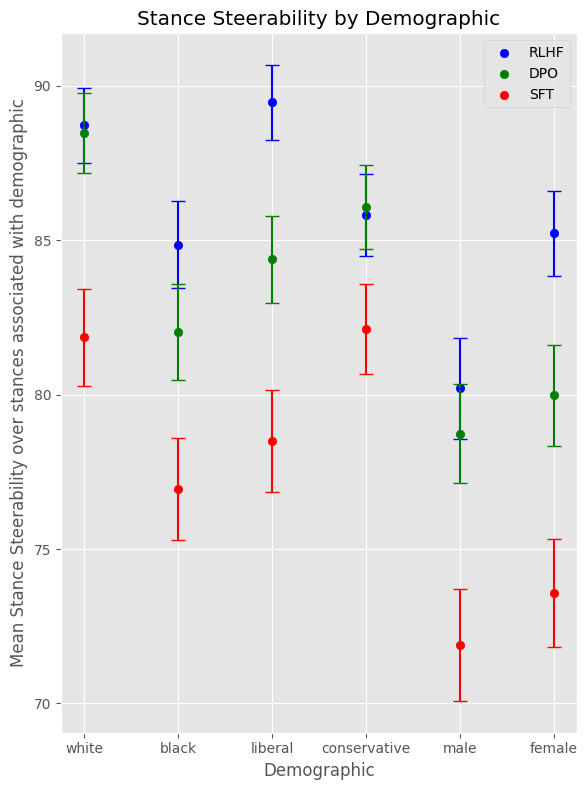

In [7]:
labels = ['white', 'black', 'liberal', 'conservative', 'male', 'female']
rlhf_values = [steerability_dict[('rlhf', label.lower())][0] for label in labels]
dpo_values = [steerability_dict[('dpo', label.lower())][0] for label in labels]
sft_values = [steerability_dict[('sft', label.lower())][0] for label in labels]
rlhf_ci = [steerability_dict[('rlhf', label.lower())][1] for label in labels]
dpo_ci = [steerability_dict[('dpo', label.lower())][1] for label in labels]
sft_ci = [steerability_dict[('sft', label.lower())][1] for label in labels]

fig, ax = plt.subplots(figsize=(6,8))
ax.scatter(y=rlhf_values, x=range(len(rlhf_values)),label='RLHF', color='blue')
ax.scatter(y=dpo_values, x=range(len(rlhf_values)), label='DPO', color='green')
ax.scatter(y=sft_values, x=range(len(rlhf_values)), label='SFT', color='red')
ax.errorbar(y=rlhf_values, x=range(len(rlhf_values)), yerr=rlhf_ci, color='blue', linestyle='', fmt='_', capsize=5)
ax.errorbar(y=dpo_values, x=range(len(rlhf_values)), yerr=dpo_ci, color='green', linestyle='',fmt='_', capsize=5)
ax.errorbar(y=sft_values, x=range(len(rlhf_values)), yerr=sft_ci, color='red', linestyle='', fmt='_', capsize=5)

# Set labels and title
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Demographic')
ax.set_ylabel('Mean Stance Steerability over stances associated with demographic')
ax.set_title('Stance Steerability by Demographic')

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.savefig('figures/stance-steerability-by-demographic.png')

### 3.2.2 - Steerability by Stance is Not Predictable from Model Survey Response Rates

In [8]:
base_df = df[df['persona'] == 'base']
base_df['id'] = base_df['topic'].apply(lambda x: p_t[x]['id'])
result_df = base_df.groupby(['id', 'model'], as_index = False)[['topic steerability', 'model_base']].agg(list).reset_index()

/tmp/ipykernel_3305176/2578385996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['id'] = base_df['topic'].apply(lambda x: p_t[x]['id'])


In [9]:
agree = 0
disagree = 0

for idx, row in result_df.iterrows():
    t_s = row['topic steerability']
    m_b = row['model_base']
    if (m_b[0] > m_b[1] and t_s[0] > t_s[1]) or (m_b[0] < m_b[1] and t_s[0] < t_s[1]):
        agree += 1
    elif (m_b[0] > m_b[1] and t_s[0] < t_s[1]) or (m_b[0] < m_b[1] and t_s[0] > t_s[1]):
        disagree += 1

print(f'MC and Steerability results agree in {agree} of {agree+disagree} cases, for a total rate of {agree/(disagree+agree):.3g}.')

MC and Steerability results agree in 80 of 167 cases, for a total rate of 0.479.


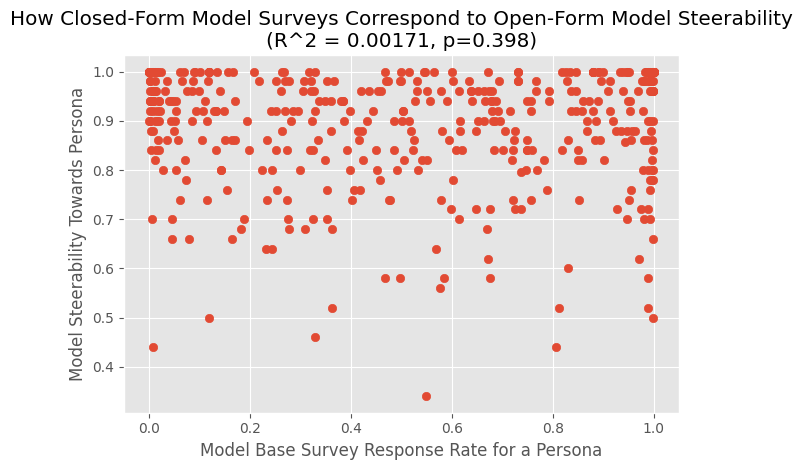

In [10]:
plt.scatter(base_df['model_base'], base_df['topic steerability'])
plt.xlabel('Model Base Survey Response Rate for a Persona')
plt.ylabel('Model Steerability Towards Persona')
statistic, pvalue = pearsonr(base_df['model_base'], base_df['topic steerability'])
plt.title(f'How Closed-Form Model Surveys Correspond to Open-Form Model Steerability\n(R^2 = {statistic**2:.3g}, p={pvalue:.3g})')
plt.savefig('figures/model-base-vs-steerability.png')

### Tables 2-4 (3.3) - Steerability Towards Congruous and Incongruous Personas

In [16]:
# Table 2 (LaTeX format)
for m in ['gpt-3.5-turbo-0613', 'Llama-2-70b-chat', 'Llama-2-7b-chat', 'tulu-2-dpo-70b', 'tulu-2-dpo-7b', 'tulu-2-70b', 'tulu-2-7b']:
    s = m
    for d in [pol_df, race_df, gen_df]:
        s += ' & '
        s += str(round(100*d[(d['model'] == m) & (d['congruity'] == 0.5)]['topic steerability'].mean(), 1))
        s += ' \\small{$\\pm '
        s += str(round(100*bootstrap_ci_construct(np.array(d[(d['model'] == m) & (d['congruity'] == 0.5)]['topic steerability'])), 1))
        s += '$}'
        s += ' & '
        s += str(round(100*d[(d['model'] == m) & (d['congruity'] > 0.5)]['topic steerability'].mean(), 1))
        s += ' \\small{$\\pm '
        s += str(round(100*bootstrap_ci_construct(np.array(d[(d['model'] == m) & (d['congruity'] > 0.5)]['topic steerability'])), 1))
        s += '$}'
        s += ' & '
        s += str(round(100*d[(d['model'] == m) & (d['congruity'] < 0.5)]['topic steerability'].mean(), 1))
        s += ' \\small{$\\pm '
        s += str(round(100*bootstrap_ci_construct(np.array(d[(d['model'] == m) & (d['congruity'] < 0.5)]['topic steerability'])), 1))
        s += '$}'
    s += '\\\\'
    print(s)
    
s = 'Average'
for d in [pol_df, race_df, gen_df]:
    s += ' & '
    s += str(round(100*d[(d['congruity'] == 0.5)]['topic steerability'].mean(), 1))
    s += ' \\small{$\\pm '
    s += str(round(100*bootstrap_ci_construct(np.array(d[(d['congruity'] == 0.5)]['topic steerability'])), 1))
    s += '$}'
    s += ' & '
    s += str(round(100*d[(d['congruity'] > 0.5)]['topic steerability'].mean(), 1))
    s += ' \\small{$\\pm '
    s += str(round(100*bootstrap_ci_construct(np.array(d[(d['congruity'] > 0.5)]['topic steerability'])), 1))
    s += '$}'
    s += ' & '
    s += str(round(100*d[(d['congruity'] < 0.5)]['topic steerability'].mean(), 1))
    s += ' \\small{$\\pm '
    s += str(round(100*bootstrap_ci_construct(np.array(d[(d['congruity'] < 0.5)]['topic steerability'])), 1))
    s += '$}'
s += '\\\\'
print(s)

gpt-3.5-turbo-0613 & 100.0 \small{$\pm 0.0$} & 100.0 \small{$\pm 0.1$} & 83.5 \small{$\pm 1.6$} & 99.8 \small{$\pm 0.2$} & 99.4 \small{$\pm 0.4$} & 98.1 \small{$\pm 0.6$} & 98.2 \small{$\pm 0.8$} & 98.0 \small{$\pm 0.6$} & 98.6 \small{$\pm 0.5$}\\
Llama-2-70b-chat & 95.1 \small{$\pm 1.2$} & 94.1 \small{$\pm 1.0$} & 78.5 \small{$\pm 1.8$} & 93.2 \small{$\pm 1.6$} & 91.9 \small{$\pm 1.2$} & 82.9 \small{$\pm 1.6$} & 86.3 \small{$\pm 2.2$} & 85.2 \small{$\pm 1.6$} & 80.6 \small{$\pm 1.8$}\\
Llama-2-7b-chat & 92.0 \small{$\pm 1.7$} & 93.4 \small{$\pm 1.0$} & 78.7 \small{$\pm 1.8$} & 89.2 \small{$\pm 1.9$} & 88.6 \small{$\pm 1.4$} & 79.4 \small{$\pm 1.8$} & 86.0 \small{$\pm 2.1$} & 84.1 \small{$\pm 1.7$} & 77.4 \small{$\pm 1.8$}\\
tulu-2-dpo-70b & 89.7 \small{$\pm 1.8$} & 90.6 \small{$\pm 1.3$} & 81.5 \small{$\pm 1.7$} & 88.3 \small{$\pm 1.9$} & 87.7 \small{$\pm 1.4$} & 81.9 \small{$\pm 1.7$} & 83.3 \small{$\pm 2.2$} & 80.0 \small{$\pm 1.7$} & 76.7 \small{$\pm 1.9$}\\
tulu-2-dpo-7b & 92.4 \s

In [18]:
# Table 3 (LaTeX)
for m in ['gpt-3.5-turbo-0613', 'Llama-2-70b-chat', 'Llama-2-7b-chat', 'tulu-2-dpo-70b', 'tulu-2-dpo-7b', 'tulu-2-70b', 'tulu-2-7b']:
    s = f'{m}'
    for metric in ['entailment_diversity', 'diversity']:
        s += ' & '
        s += str(round(df[(df['model'] == m)][metric].mean(), 3))
        s += ' \small{$\pm '
        s += str(round(bootstrap_ci(np.array(df[metric])), 3))
        s += '$}'
    s += ' \\\\'
    print(s)

gpt-3.5-turbo-0613 & -0.45 \small{$\pm 0.008$} & 0.186 \small{$\pm 0.006$} \\
Llama-2-70b-chat & -0.052 \small{$\pm 0.008$} & 0.415 \small{$\pm 0.006$} \\
Llama-2-7b-chat & -0.094 \small{$\pm 0.009$} & 0.353 \small{$\pm 0.006$} \\
tulu-2-dpo-70b & 0.044 \small{$\pm 0.009$} & 0.478 \small{$\pm 0.006$} \\
tulu-2-dpo-7b & -0.01 \small{$\pm 0.009$} & 0.431 \small{$\pm 0.006$} \\
tulu-2-70b & 0.055 \small{$\pm 0.008$} & 0.535 \small{$\pm 0.006$} \\
tulu-2-7b & 0.046 \small{$\pm 0.009$} & 0.522 \small{$\pm 0.006$} \\


In [14]:
# Table 4 (LaTeX)
for metric in ['entailment_diversity', 'diversity', 'individuation', 'exaggeration']:
    s = f'{metric} & '
    s += str(round(df[df['congruity'] > 0.5][metric].mean(), 3))
    s += ' \\small{$\\pm '
    s += str(round(bootstrap_ci(np.array(df[df['congruity'] > 0.5][metric])), 3))
    s += '} & '

    s += str(round(df[df['congruity'] < 0.5][metric].mean(), 3))
    s += ' \\small{$\\pm '
    s += str(round(bootstrap_ci(np.array(df[df['congruity'] < 0.5][metric])), 3))
    s += '} \\\\'
    print(s)

entailment_diversity & -0.054 \small{$\pm 0.013} & -0.06 \small{$\pm 0.014} \\
diversity & 0.431 \small{$\pm 0.01} & 0.416 \small{$\pm 0.009} \\
individuation & 0.624 \small{$\pm 0.008} & 0.655 \small{$\pm 0.009} \\
exaggeration & 0.146 \small{$\pm 0.01} & 0.114 \small{$\pm 0.008} \\
